In [1]:
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from openap import aero, nav

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from spektral.data.loaders import SingleLoader, DisjointLoader, BatchLoader
from spektral.layers import GATConv, DiffusionConv, GCNConv
from spektral.transforms import LayerPreprocess

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import seaborn as sns

pd.set_option("display.max_columns", None)

tf.config.list_physical_devices("GPU")

2023-03-13 17:44:37.596498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:44:37.688515: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
start_year, end_year = 2016, 2019

start = datetime(start_year, 1, 1)
end = datetime(end_year, 12, 31)

agg_interval = 30  # minutes

## Load Data

In [3]:
files = sorted(glob.glob("data/airport/*.parquet"))

data = {}
airports = []

for file in tqdm(files):
    ap = Path(file).stem
    airports.append(ap)
    
    d =  pd.read_parquet(file).sort_values('timeslot')
    X = d.drop(["delay_arrival", "delay_departure"], axis=1)
    Y = d[["delay_arrival", "delay_departure"]].copy()
    T = d[["timeslot"]]
    
    data[ap] = {}
    data[ap]['X'] = X
    data[ap]['Y'] = Y
    data[ap]['T'] = T



100%|██████████| 50/50 [00:00<00:00, 84.77it/s]


In [4]:
# train_dates = d.query("date<'2019-01-01'").date.unique()
# test_dates = d.query("date>='2019-01-01'").date.unique()

train_dates = d.query("date<'2019-09-01'").date.unique()
test_dates = d.query("date>='2019-09-01'").date.unique()

In [5]:
X_all = pd.concat([d["X"] for ap, d in data.items()]).drop(["timeslot", "date"], axis=1)
Y_all = pd.concat([d["Y"] for ap, d in data.items()])

scaler = StandardScaler()
scaler.fit(pd.concat([X_all, Y_all], axis=1))


StandardScaler()

In [ ]:
# corr = (pd.concat([X_all, Y_all], axis=1)).corr().round(2)

# plt.figure(figsize=(15, 15))
# plt.tight_layout()
# heat_map = sns.heatmap(
#     corr,
#     linewidth=1,
#     annot=True,
#     center=0,
#     cmap="Spectral_r",
#     vmin=-1,
#     vmax=1,
#     square=True,
#     # xticklabels=ticks,
#     # yticklabels=ticks,
# )
# # heat_map.set_xticklabels(ticks, rotation=30, ha="right")
# plt.show()


In [6]:
X_train = []
Y_train = []
X_test = []
Y_test = []


for airport in tqdm(airports):
    xy = pd.concat([data[airport]["X"], data[airport]["Y"]], axis=1)
    xy_train = xy.query("date in @train_dates")
    xy_test = xy.query("date in @test_dates")

    # train: size T x F
    x_train = xy_train.drop(columns=["timeslot", "date"])
    y_train = xy_train[["delay_arrival", "delay_departure"]]
    X_train.append(scaler.transform(x_train))
    Y_train.append(y_train)

    # test: size T x F
    x_test = xy_test.drop(columns=["timeslot", "date"])
    y_test = xy_test[["delay_arrival", "delay_departure"]]
    X_test.append(scaler.transform(x_test))
    Y_test.append(y_test)

X_train = np.stack(X_train)
Y_train = np.stack(Y_train)
X_test = np.stack(X_test)
Y_test = np.stack(Y_test)

# N x T x F
X_train = np.swapaxes(X_train, 0, 1)
Y_train = np.swapaxes(Y_train, 0, 1)
X_test = np.swapaxes(X_test, 0, 1)
Y_test = np.swapaxes(Y_test, 0, 1)

print(f"T x AP x F: X_train = {X_train.shape} | Y_train = {Y_train.shape}")
print(f"T x AP x F: X_test  = {X_test.shape} | Y_test  = {Y_test.shape}")


100%|██████████| 50/50 [00:00<00:00, 57.13it/s]

T x AP x F: X_train = (20496, 50, 27) | Y_train = (20496, 50, 2)
T x AP x F: X_test  = (2881, 50, 27) | Y_test  = (2881, 50, 2)


## Generate Adjacency Matrices

## distance adjacency matrix

describes the geographical closeness of two airports. for capturing the correlations of airspace situations for airports that are located closer to each other

In [7]:
# distance threshold (km), beyond which the weight is 0
threshold = 400

# vectorize distance pair calculation
ap_coordinates = [(nav.airport(ap)["lat"], nav.airport(ap)["lon"]) for ap in airports]
mg = np.meshgrid(ap_coordinates, ap_coordinates)
xx = mg[0].reshape(len(airports), -1, 2)[:, 0:len(airports), :]
yy = np.swapaxes(xx, 0, 1)


dist = aero.distance(xx[:, :, 0], xx[:, :, 1], yy[:, :, 0], yy[:, :, 1]) // 1000
std = np.std(dist)

adj_distance = np.where(dist < threshold, np.exp(-(dist ** 2) / std ** 2), 0)

adj_distance.shape


(50, 50)

## flight adjacency matrix

the number of flights between two airports at each time interval. this matrix is dynamically updated for each time step between all airport pairs

In [8]:
df_net = (
    pd.read_parquet("data/all_flights.parquet")
    .query("ap0.isin(@airports) and ap1.isin(@airports)")
    .assign(fat_slot=lambda x: x.fat.dt.floor(f"{agg_interval}T"))
    .assign(date=lambda x: pd.to_datetime(x.fobt.dt.date))[
        ["flight_id", "date", "ap0", "ap1", "fobt", "fat", "fat_slot"]
    ]
)

df_net.head()


,flight_id,date,ap0,ap1,fobt,fat,fat_slot
1,194418059,2016-03-01,OMDB,EFHK,2016-03-01 00:00:00,2016-03-01 07:04:25,2016-03-01 07:00:00
16,194418078,2016-03-01,OMDB,UKBB,2016-03-01 00:05:00,2016-03-01 05:22:06,2016-03-01 05:00:00
22,194418084,2016-03-01,LIRF,EGKK,2016-03-01 00:05:00,2016-03-01 02:26:36,2016-03-01 02:00:00
68,194418132,2016-03-01,LIRF,EGKK,2016-03-01 00:17:00,2016-03-01 02:47:28,2016-03-01 02:30:00
98,194418163,2016-03-01,LFPG,LFLL,2016-03-01 00:25:00,2016-03-01 01:32:52,2016-03-01 01:30:00


In [9]:
def gen_adj_flights(dates, interval="30T"):

    # number of flights between airport pairs
    df_net_train = (
        df_net.query("date in @dates")
        .drop(columns=["date"])
        .groupby(["fat_slot", "ap1"])["ap0"]
        .value_counts()
        .unstack(fill_value=0)
    )

    # generate multindex for the adjacency matrix
    timeslots = [
        item
        for sublist in [
            pd.date_range(start=d, end=d + pd.Timedelta(days=1), freq=interval, inclusive="left")
            .to_series()
            .dt.to_pydatetime()
            .tolist()
            for d in dates
        ]
        for item in sublist
    ]

    multi_idx = pd.MultiIndex.from_product([timeslots, airports])

    # ensure all timeslots and airports are listed
    df_net_train = df_net_train.reindex(multi_idx, fill_value=0)

    # Generate numpy adjacency matrix in 3d format
    mat3d = df_net_train.to_numpy().reshape(-1, len(airports), len(airports))

    # Normalise the matrix
    maximum = np.amax(mat3d, axis=0)
    new_maximum = np.where(maximum == 0, 1, maximum)
    mat3d_norm = mat3d / new_maximum

    return mat3d_norm


In [10]:
adj_flight_train = gen_adj_flights(train_dates)
adj_flight_test = gen_adj_flights(test_dates)

adj_flight_train.shape, adj_flight_test.shape

((20496, 50, 50), (2928, 50, 50))

### merge two adjacency matrix

In [11]:
A_train = adj_distance * 0.4 + (1 - 0.4) * adj_flight_train
A_test = adj_distance * 0.4 + (1 - 0.4) * adj_flight_test

# Create tensorflow dataset

In [12]:
def createDataset(
    X: np.ndarray,
    A: np.ndarray,
    Y: np.ndarray,
    lookback: int,
    lookahead: int,
    batch_size: int = 64,
):

    # make windows
    idx = 0
    X_ = []
    A_ = []
    Y_ = []

    while idx + lookback + lookahead < len(X):
        # features
        # x = X[idx : idx + lookback, :, :]
        x = np.append(X[idx : idx + lookback, :, :], Y[idx : idx + lookback, :, :], axis=2)
        X_.append(x)

        # adjacency matrix
        a = A[idx : idx + lookback, :, :]
        A_.append(a)

        # make labels with multi-horizon
        y = Y[idx + lookback : idx + lookback + lookahead, :, :]
        Y_.append(y)

        idx += 1

    X = np.array(X_)
    A = np.array(A_)
    Y = np.array(Y_)

    # Ensure only complete batches are made (remove incomplete ones)
    batchCutoff = X.shape[0] - (X.shape[0] % batch_size)

    X, A, Y = (
        X[:batchCutoff, :, :, :],
        A[:batchCutoff, :, :, :],
        Y[:batchCutoff, :, :, :],
    )

    with tf.device("CPU"):
        dataset = tf.data.Dataset.from_tensor_slices(
            ((X, A), Y)
        ).batch(batch_size)

    return dataset


In [13]:
epochs = 100
patience = 5
lookback = 8
lookahead = 8
batch_size = 64

In [14]:
train_dataset = createDataset(X_train, A_train, Y_train, lookback, lookahead, batch_size)
test_dataset = createDataset(X_test, A_test, Y_test, lookback, lookahead, batch_size)

print(train_dataset)
print(test_dataset)


2023-03-13 17:45:28.580511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 17:45:29.150417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6099 MB memory:  -> device: 0, name: NVIDIA T1000 8GB, pci bus id: 0000:65:00.0, compute capability: 7.5


<BatchDataset element_spec=((TensorSpec(shape=(None, 8, 50, 29), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8, 50, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 8, 50, 2), dtype=tf.float64, name=None))>
<BatchDataset element_spec=((TensorSpec(shape=(None, 8, 50, 29), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8, 50, 50), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 8, 50, 2), dtype=tf.float64, name=None))>


## GNN Model

In [15]:
# channels = 30
# attn_heads = 30
channels = 10
attn_heads = 10

lstm_units = 60

n_features = X_train.shape[2] + Y_train.shape[2]  # t-back to t0
n_targets = Y_train.shape[2]  # t0 to t+forward

n_nodes = len(airports)


In [16]:
x_in = layers.Input(
    shape=(lookback, n_nodes, n_features), batch_size=batch_size, name="Features"
)
a_in = layers.Input(
    shape=(lookback, n_nodes, n_nodes), batch_size=batch_size, name="Adjacencies"
)

x_inn = tf.reshape(x_in, (batch_size * lookback, n_nodes, n_features))
a_inn = tf.reshape(a_in, (batch_size * lookback, n_nodes, n_nodes))

gatout = GATConv(channels=channels, attn_heads=attn_heads, dropout_rate=0.2, name="GAT")([x_inn, a_inn])
print(gatout.shape)

reshape1 = tf.reshape(gatout, (batch_size, lookback, n_nodes, attn_heads * channels))
print(reshape1.shape)

reshape1 = tf.transpose(reshape1, [0, 2, 1, 3])
print(reshape1.shape)

reshape1 = tf.reshape(reshape1, (batch_size * n_nodes, lookback, attn_heads * channels))
print(reshape1.shape)

lstm1 = layers.LSTM(lstm_units, dropout=0.1, return_sequences=True, name="LSTM1")(reshape1)
lstm2 = layers.LSTM(lstm_units, dropout=0.1, return_sequences=False, name="LSTM2")(lstm1)
print(lstm2.shape)

dense1 = layers.Dense(lstm_units, name="Dense1")(lstm2)
dense1 = tf.keras.layers.Dropout(0.1)(dense1)

print(dense1.shape)


dense2 = layers.Dense(n_targets * lookahead, name="DenseFinal")(dense1)
print(dense2.shape)

output = tf.reshape(
    dense2, (batch_size, n_nodes, lookahead, n_targets), name="ReshapeFinal"
)
# output = tf.reshape(dense2, (n_nodes, batch_size, lookahead, n_targets), name="ReshapeFinal")
print(output.shape)

output = tf.transpose(output, [0, 2, 1, 3], name="Re-orderToOutput")
print(output.shape)


/home/junzi/mambaforge/envs/gatdelay/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


(512, 50, 100)
(64, 8, 50, 100)
(64, 50, 8, 100)
(3200, 8, 100)
(3200, 60)
(3200, 60)
(3200, 16)
(64, 50, 8, 2)
(64, 8, 50, 2)


In [17]:
model = keras.Model(inputs=[x_in, a_in], outputs=output, name="DST-GAT")

model.compile(optimizer=Adam(), loss="mse")
# model.compile(optimizer=Adam(), loss="huber_loss")


model.summary()

Model: "DST-GAT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features (InputLayer)          [(64, 8, 50, 29)]    0           []                               
                                                                                                  
 Adjacencies (InputLayer)       [(64, 8, 50, 50)]    0           []                               
                                                                                                  
 tf.reshape (TFOpLambda)        (512, 50, 29)        0           ['Features[0][0]']               
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (512, 50, 50)        0           ['Adjacencies[0][0]']            
                                                                                            

In [18]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[es],
    shuffle=False,
)


Epoch 1/100


2023-03-13 17:45:46.848155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-13 17:45:46.984096: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5578debba6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-13 17:45:46.984144: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA T1000 8GB, Compute Capability 7.5
2023-03-13 17:45:46.987797: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-13 17:45:47.044034: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-13 17:45:47.115704: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 22s 58ms/step - loss: 77.4309 - val_loss: 68.8968
Epoch 2/100
320/320 [==============================] - 18s 56ms/step - loss: 72.5740 - val_loss: 65.8736
Epoch 3/100
320/320 [==============================] - 18s 56ms/step - loss: 70.3182 - val_loss: 64.6391
Epoch 4/100
320/320 [==============================] - 18s 56ms/step - loss: 69.0315 - val_loss: 64.0821
Epoch 5/100
320/320 [==============================] - 18s 56ms/step - loss: 68.3273 - val_loss: 63.6439
Epoch 6/100
320/320 [==============================] - 18s 56ms/step - loss: 67.6805 - val_loss: 63.3278
Epoch 7/100
320/320 [==============================] - 18s 56ms/step - loss: 67.1783 - val_loss: 62.9844
Epoch 8/100
320/320 [==============================] - 18s 56ms/step - loss: 66.7494 - val_loss: 62.7842
Epoch 9/100
320/320 [==============================] - 18s 56ms/step - loss: 66.4194 - val_loss: 62.5135
Epoch 10/100
320/320 [==============================] - 18s 56ms/st

# Analysis


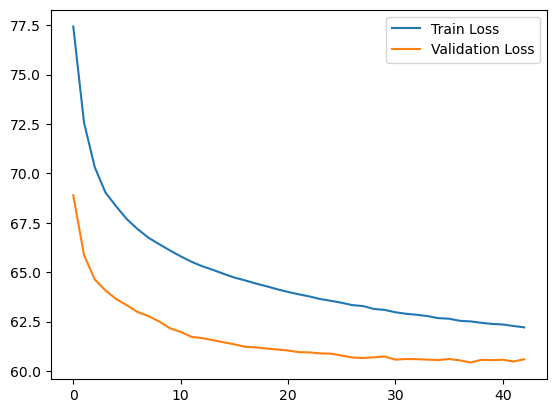

In [19]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [20]:
Y_pred = model.predict(test_dataset)


44/44 [==============================] - 2s 22ms/step


## Generate output dataset

In [21]:
buffer = []

for i, airport in enumerate(airports):
    xy = pd.concat([data[airport]["X"], data[airport]["Y"]], axis=1)
    xy_test = xy.query("date in @test_dates").iloc[lookback:]

    # Test delay metric, column represent lookahead time
    arr_delay = Y_test[lookback:, i, 0]
    n_row = len(arr_delay) - lookahead
    arr_delays = np.empty((n_row, lookahead))
    for k in range(lookahead):
        arr_delays[:, k] = arr_delay[k : k + n_row]

    dep_delay = Y_test[lookback:, i, 1]
    n_row = len(dep_delay) - lookahead
    dep_delays = np.empty((n_row, lookahead))
    for k in range(lookahead):
        dep_delays[:, k] = dep_delay[k : k + n_row]

    airport_delays = (
        pd.concat(
            [
                pd.DataFrame().assign(time=xy_test["timeslot"].values),
                pd.DataFrame(
                    arr_delays.round().astype(int),
                    columns=[f"arr_{30*n}m" for n in range(1, lookahead + 1)],
                ),
                pd.DataFrame(
                    dep_delays.round().astype(int),
                    columns=[f"dep_{30*n}m" for n in range(1, lookahead + 1)],
                ),
                pd.DataFrame(
                    Y_pred[:, :, i, 0].round().astype(int),
                    columns=[f"arr_est_{30*n}m" for n in range(1, lookahead + 1)],
                ),
                pd.DataFrame(
                    Y_pred[:, :, i, 1].round().astype(int),
                    columns=[f"dep_est_{30*n}m" for n in range(1, lookahead + 1)],
                ),
            ],
            axis=1,
        )
        .dropna()
        .assign(airport=airport)
    )

    buffer.append(airport_delays)

results = pd.concat(buffer, ignore_index=True)


In [ ]:
# results.to_csv("data/network_delay_gnn_results.csv", index=False)

In [22]:
df = results.assign(time=lambda d: pd.to_datetime(d.time)).assign(
    date=lambda d: d.time.dt.date
)

res_arr = dict()
res_dep = dict()
for i in range(1, lookahead+1):
    res_arr[i] = {
        "Lookahead": f"{i*30} min",
        "MAE": mean_absolute_error(df[f"arr_{i*30}m"], df[f"arr_est_{i*30}m"]),
        "RMSE": mean_squared_error(
            df[f"arr_{i*30}m"], df[f"arr_est_{i*30}m"], squared=False
        ),
        "R2": r2_score(df[f"arr_{i*30}m"], df[f"arr_est_{i*30}m"]),
    }
    res_dep[i] = {
        "Lookahead": f"{i*30} min",
        "MAE": mean_absolute_error(df[f"dep_{i*30}m"], df[f"dep_est_{i*30}m"]),
        "RMSE": mean_squared_error(
            df[f"dep_{i*30}m"], df[f"dep_est_{i*30}m"], squared=False
        ),
        "R2": r2_score(df[f"dep_{i*30}m"], df[f"dep_est_{i*30}m"]),
    }

stats_arr = pd.DataFrame.from_dict(res_arr, orient="index")
stats_dep = pd.DataFrame.from_dict(res_dep, orient="index")

display(stats_arr)
display(stats_dep)


,Lookahead,MAE,RMSE,R2
1,30 min,5.724972,8.715443,0.319437
2,60 min,5.775987,8.789736,0.307785
3,90 min,5.827926,8.865564,0.296062
4,120 min,5.872187,8.933821,0.285235
5,150 min,5.906484,8.981665,0.277527
6,180 min,5.930717,9.018136,0.271645
7,210 min,5.953068,9.053713,0.265812
8,240 min,5.992933,9.103893,0.257604


,Lookahead,MAE,RMSE,R2
1,30 min,4.050959,6.270387,0.354939
2,60 min,4.072678,6.325543,0.343569
3,90 min,4.108047,6.381999,0.331255
4,120 min,4.148075,6.440098,0.319141
5,150 min,4.184098,6.489816,0.308480
6,180 min,4.221697,6.534592,0.298628
7,210 min,4.255284,6.571741,0.289807
8,240 min,4.299595,6.620420,0.278694


In [23]:
def plot_delay(airport):
    df = results.query('airport == @airport')

    fig, axes = plt.subplots(5, 1, figsize=(20, 8), sharex=True, sharey=True)

    axes[0].set_title(f"{airport} - Arrival delay (min)")

    ax = axes[0]
    ax.plot(df.arr_30m, alpha=0.9, label="Actual")
    ax.plot(df.arr_est_30m, color="r", alpha=0.8, label="Predicted (-30 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
    ax.set_ylim(-20, 80)

    ax = axes[1]
    ax.plot(df.arr_60m, alpha=0.9, label="Actual")
    ax.plot(df.arr_est_60m, color="r", alpha=0.8, label="Predicted (-60 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    ax = axes[2]
    ax.plot(df.arr_120m, alpha=0.9, label="Actual")
    ax.plot(df.arr_est_120m, color="r", alpha=0.8, label="Predicted (-120 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    ax = axes[3]
    ax.plot(df.arr_180m, alpha=0.9, label="Actual")
    ax.plot(df.arr_est_180m, color="r", alpha=0.8, label="Predicted (-180 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    ax = axes[4]
    ax.plot(df.arr_240m, alpha=0.9, label="Actual")
    ax.plot(df.arr_est_240m, color="r", alpha=0.8, label="Predicted (-240 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    # ax = axes[5]
    # ax.plot(df.arr_300m, alpha=0.9, label="Actual")
    # ax.plot(df.arr_est_300m, color="r", alpha=0.8, label="Predicted (-300 min)")
    # ax.axhline(0, ls=":")
    # ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(5, 1, figsize=(20, 8), sharex=True, sharey=True)

    axes[0].set_title(f"{airport} - Departure delay (min)")

    ax = axes[0]
    ax.plot(df.dep_30m, alpha=0.9, label="Actual")
    ax.plot(df.dep_est_30m, color="r", alpha=0.8, label="Predicted (-30 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
    ax.set_ylim(-20, 40)

    ax = axes[1]
    ax.plot(df.dep_60m, alpha=0.9, label="Actual")
    ax.plot(df.dep_est_60m, color="r", alpha=0.8, label="Predicted (-60 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    ax = axes[2]
    ax.plot(df.dep_120m, alpha=0.9, label="Actual")
    ax.plot(df.dep_est_120m, color="r", alpha=0.8, label="Predicted (-120 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    ax = axes[3]
    ax.plot(df.dep_180m, alpha=0.9, label="Actual")
    ax.plot(df.dep_est_180m, color="r", alpha=0.8, label="Predicted (-180 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    ax = axes[4]
    ax.plot(df.dep_240m, alpha=0.9, label="Actual")
    ax.plot(df.dep_est_240m, color="r", alpha=0.8, label="Predicted (-240 min)")
    ax.axhline(0, ls=":")
    ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    # ax = axes[5]
    # ax.plot(df.dep_300m, alpha=0.9, label="Actual")
    # ax.plot(df.dep_est_300m, color="r", alpha=0.8, label="Predicted (-300 min)")
    # ax.axhline(0, ls=":")
    # ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

    plt.tight_layout()
    plt.show()



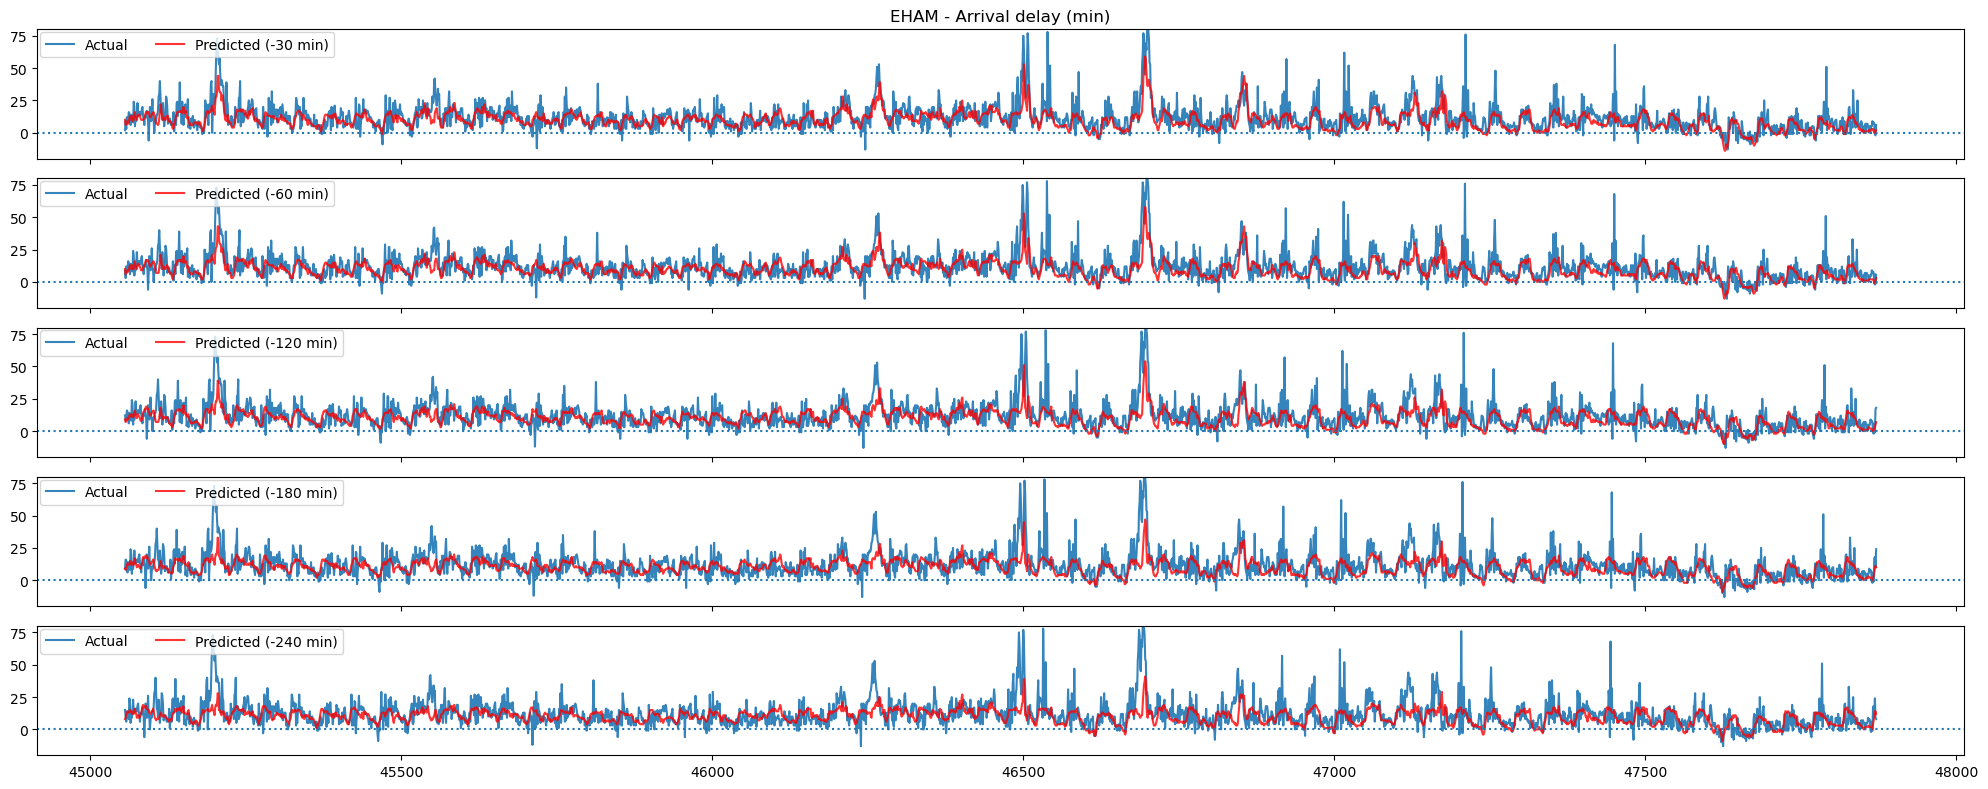

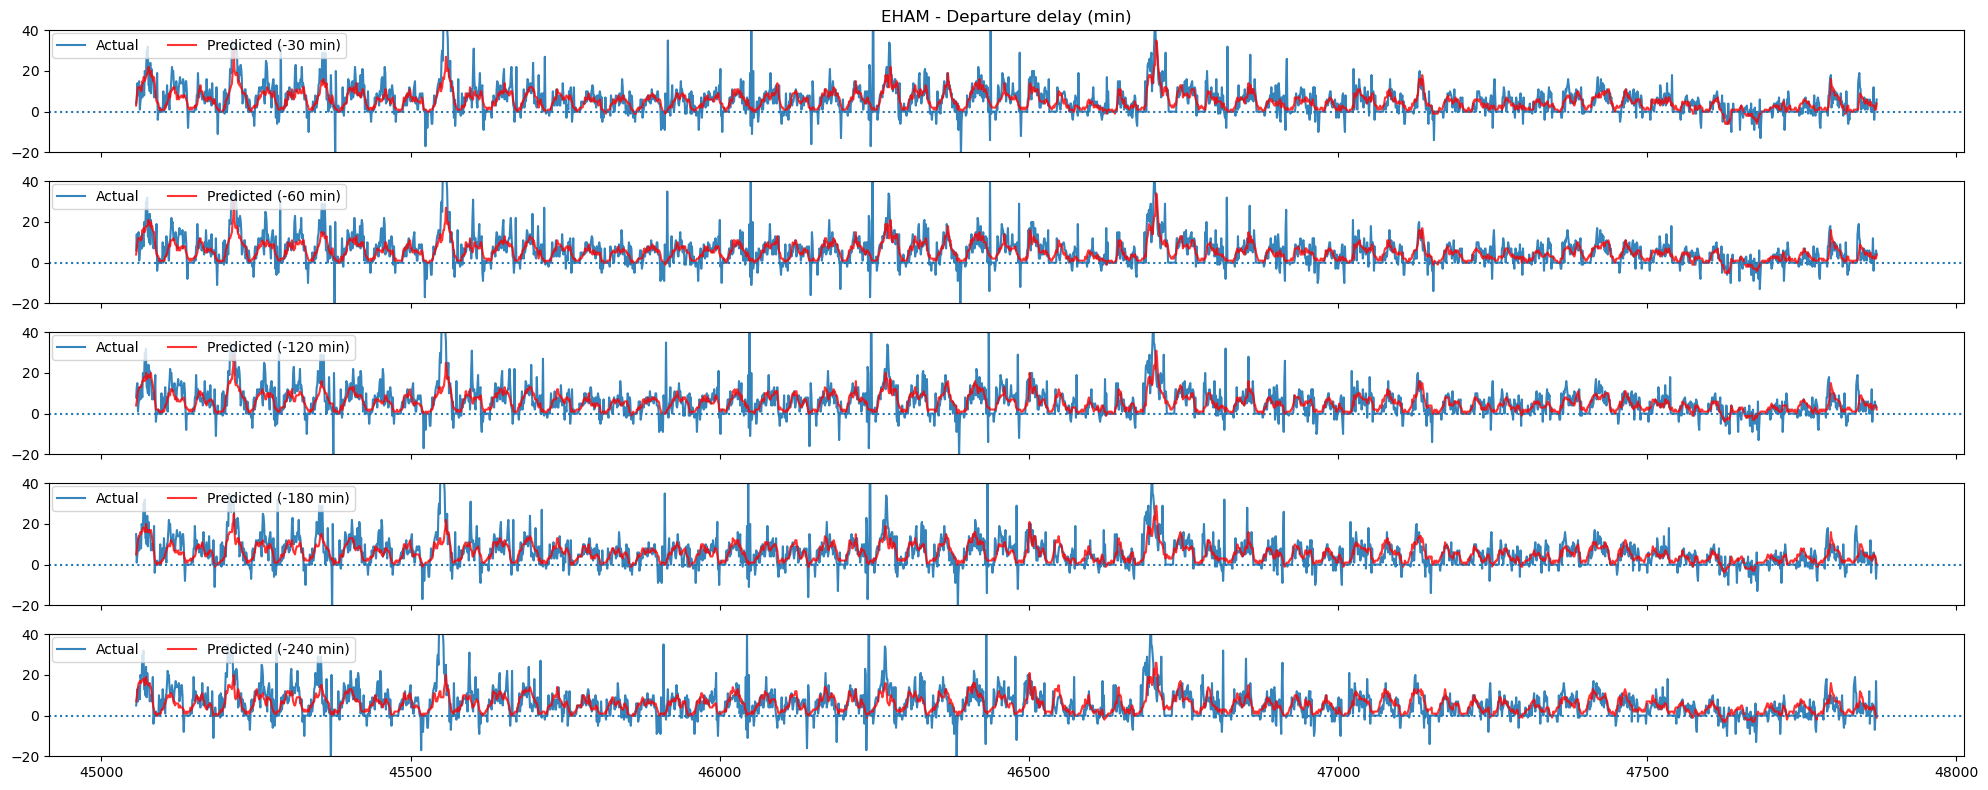

In [24]:
plot_delay("EHAM")